<a href="https://colab.research.google.com/github/praveenraghuvanshi1512/EVA4/blob/master/Session-12/Assignment-12/Assignment-12-B/EVA4_S12_A12_B_Praveen_Raghuvanshi_KMeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2
  
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import os 
BASE_COLAB_PATH = '/content/drive/My Drive/eva-4/assignment-12/assignment-12-B/'

os.chdir(BASE_COLAB_PATH)
!ls


50_dogAnnotations  EVA4-S12-A12-B-Praveen-Raghuvanshi-KMeans.ipynb
50_dogImages


In [0]:
import os,json,math
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.cluster import KMeans 
from sklearn import metrics 
from scipy.spatial.distance import cdist 
import numpy as np 
import matplotlib.pyplot as plt  
import pandas as pd
%matplotlib inline
from tqdm.notebook import tqdm, trange
path = './50_dogImages/'
from skimage import io
imagesizesdict = {}
for fileobj in os.listdir(path):
  imgobj = io.imread(f'{path}{fileobj}', as_gray=False, pilmode="RGB")
  imagesizesdict[fileobj] = imgobj.shape[:2]

I downloaded data at:

In [4]:
annot_json = json.load(open('./50_dogAnnotations/via_export_json.json'))
df = pd.DataFrame()
datadict = []
for k, v in annot_json.items():
  for row in v['regions']:
    rec = {'name': v['filename'] }
    shape = row['shape_attributes']
    h, w = imagesizesdict[v['filename']]
    rec['h'] = shape['height']
    rec['w'] = shape['width']
    rec['x'] = shape['x']
    rec['y'] = shape['y']
    rec['image_w'] = w
    rec['image_h'] = h
    rec['height'] = shape['height']/h
    rec['width'] = shape['width']/w
    rec['log_height'] = math.log(shape['height']/h)
    rec['log_width'] = math.log(shape['width']/h)

    datadict.append(rec)


df = pd.DataFrame.from_dict(datadict, orient='columns')
df


,name,h,w,x,y,image_w,image_h,height,width,log_height,log_width
0,alan-king-KZv7w34tluA-unsplash.jpg,5631,4432,157,2022,5304,7952,0.708124,0.835596,-0.345136,-0.584573
1,alicia-jones-13Nt3KvEQ3w-unsplash.jpg,1227,774,774,439,2896,1944,0.631173,0.267265,-0.460176,-0.920931
2,alvan-nee-9M0tSjb-cpA-unsplash.jpg,1830,1511,444,1413,2366,3555,0.514768,0.638631,-0.664039,-0.855583
3,alvan-nee-eoqnr8ikwFE-unsplash.jpg,2596,1949,413,1036,2744,4049,0.641146,0.710277,-0.444498,-0.731154
4,alvan-nee-T-0EW-SEbsE-unsplash.jpg,2365,1424,1177,836,5784,3861,0.612536,0.246196,-0.490148,-0.997456
...,...,...,...,...,...,...,...,...,...,...,...
57,tamara-bellis-VLKvzQQiR3o-unsplash.jpg,2676,2316,2426,603,6016,4000,0.669000,0.384973,-0.401971,-0.546453
58,tony-trocino-mJBn7QQhZSQ-unsplash.jpg,2408,3656,373,589,5184,3456,0.696759,0.705247,-0.361315,0.056258
59,treddy-chen-6uzz9iIsPoM-unsplash.jpg,1244,2646,994,1933,6000,4000,0.311000,0.441000,-1.167962,-0.413245
60,victor-grabarczyk-N04FIfHhv_k-unsplash.jpg,3335,3220,2030,640,6000,4000,0.833750,0.536667,-0.181822,-0.216913


In [0]:
def iou(box, centroids):
    x = np.minimum(np.exp(centroids[:, 0]), np.exp(box[0]))
    y = np.minimum(np.exp(centroids[:, 1]), np.exp(box[1]))

    intersection = x * y
    box_area = np.exp(box[0]) * np.exp(box[1])
    centroid_area = np.exp(centroids[:, 0]) * np.exp(centroids[:, 1])

    iou_ = intersection / (box_area + centroid_area - intersection)
    #return iou_
    return (np.max(iou_), np.argmax(iou_))

X = df[['log_width', 'log_height']].to_numpy()

In [0]:
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
centroids = {}
memberships = {}
miou = []
K = range(1, 21)

for k in K:
  kmeansModel = KMeans(n_clusters=k).fit(X)
  distortions.append(sum(np.min(cdist(X, kmeansModel.cluster_centers_, 
                      'euclidean'),axis=1)) / X.shape[0]) 
  inertias.append(kmeansModel.inertia_) 

  mapping1[k] = sum(np.min(cdist(X, kmeansModel.cluster_centers_, 
                'euclidean'),axis=1)) / X.shape[0] 
  mapping2[k] = kmeansModel.inertia_ 
  centroids[k] = kmeansModel.cluster_centers_
  maxiou = np.array([iou(b, centroids[k])  for b in X])
  memberships[k] = maxiou[:, 1].astype(np.uint8)
  # find mean of maximum IOU between bounding boxes and individual anchors
  miou.append(np.mean(maxiou[:, 0]))

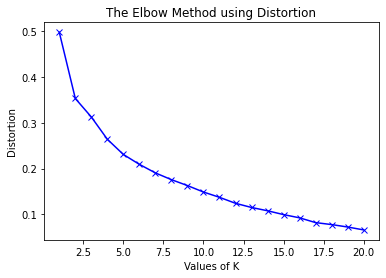

In [7]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

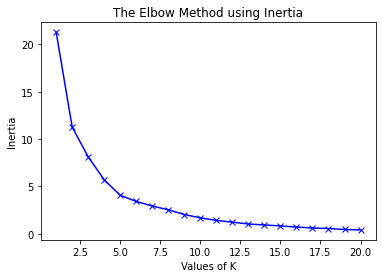

In [8]:
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

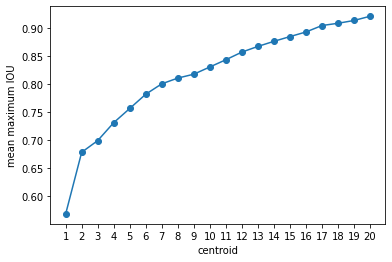

In [9]:
def plotIOU(X, Y):
  plt.scatter(X, Y)
  plt.plot(X, Y)
  plt.xlabel("centroid")
  plt.ylabel("mean maximum IOU")
  plt.xticks(np.arange(1, 21))
  plt.show()

plotIOU(K, miou)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


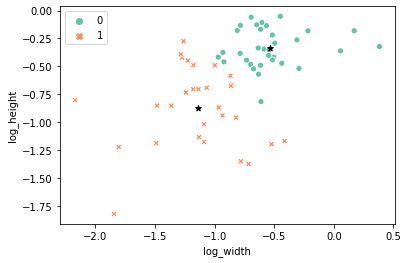

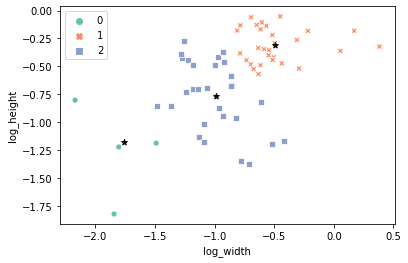

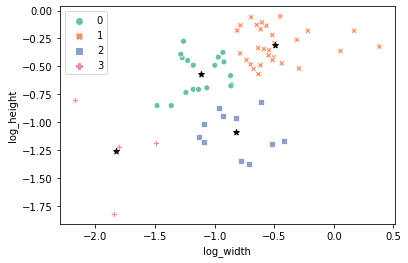

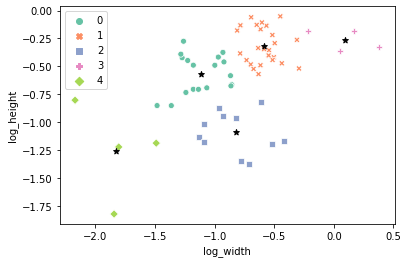

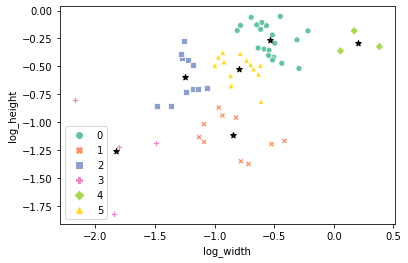

In [10]:
import seaborn as sns
def plotclusters(k):
  #ax = df.plot.scatter('log_width', 'log_height', c=f'cluster{k}', colormap='viridis')
  ax = sns.scatterplot('log_width', 'log_height', data=df, hue=memberships[k], style = memberships[k], palette="Set2")
  ax.scatter(centroids[k][:,0], centroids[k][:,1], marker='*', c='black')
  plt.show()

for k in range(2,7):
  plotclusters(k)

In [0]:
def ioudist(box, centroid):
    #print(centroid)
    x = np.minimum(np.exp(centroid[0]), np.exp(box[0]))
    y = np.minimum(np.exp(centroid[1]), np.exp(box[1]))

    intersection = x * y
    box_area = np.exp(box[0]) * np.exp(box[1])
    centroid_area = np.exp(centroid[0]) * np.exp(centroid[1])

    iou_ = intersection / (box_area + centroid_area - intersection)
    return 1 - iou_

In [12]:
!pip install pyclustering

     |████████████████████████████████| 2.6MB 45.3MB/s 
  Created wheel for pyclustering: filename=pyclustering-0.9.3.1-cp36-none-any.whl size=2599356 sha256=7b1ec67385597d317c5b9724cd5a5c29b641a290d7e8aa2e1fef5deed159ff63
  Stored in directory: /root/.cache/pip/wheels/34/d6/ac/59746c226a35752edcd786d3ab96f9b547a2b70d0fbda92015
Successfully built pyclustering


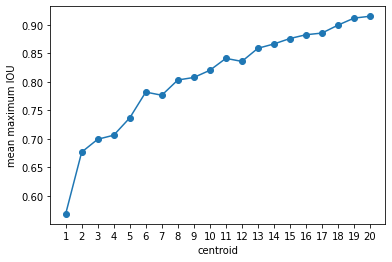

In [13]:
from pyclustering.cluster.kmeans import kmeans, kmeans_visualizer
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.utils.metric import type_metric, distance_metric

metric = distance_metric(type_metric.USER_DEFINED, func=ioudist)
clusters = []
final_centers = []
mean_iou = []
for k in K:
  # Prepare initial centers using K-Means++ method.
  initial_centers = kmeans_plusplus_initializer(X, k).initialize()

  if k==1:
    kmeans_instance = kmeans(X, initial_centers)  
  else:
    kmeans_instance = kmeans(X, initial_centers, metric=metric)

  kmeans_instance.process()
  clusters.append(kmeans_instance.get_clusters())
  c = np.array(kmeans_instance.get_centers())
  final_centers.append(c)
  maxiou = np.array([iou(b, c)  for b in X])
  mean_iou.append(np.mean(maxiou[:, 0]))
plotIOU(K, mean_iou)

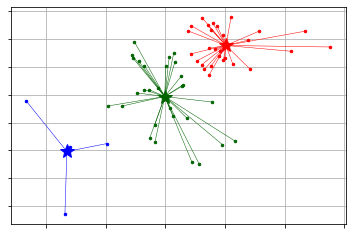

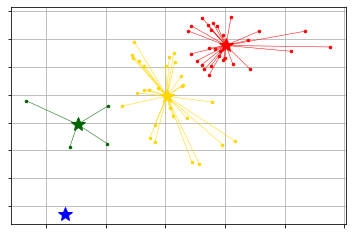

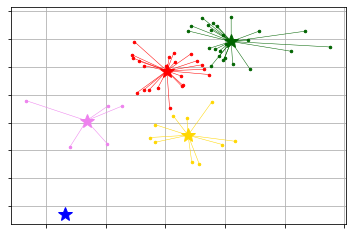

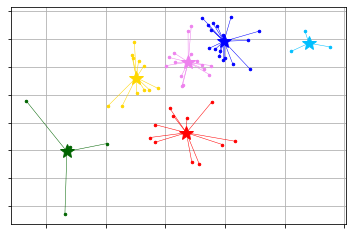

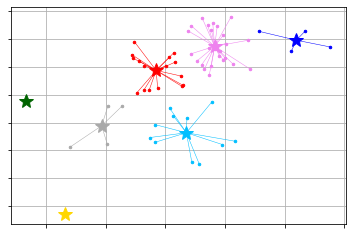

In [14]:
for k in range(2, 7):
  kmeans_visualizer.show_clusters(X, clusters[k], final_centers[k])

## Visualize the clustering data
It is hard to see if there is any clearly separated clusters. 

In [0]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

def make_anchor_boxes(ax, clusters, facecolor='None', edgecolor='b', alpha=1):

    xdata = np.array([0.5]*len(clusters))
    ydata = np.array([0.5]*len(clusters))

    xerr = np.array([list(np.exp(clusters[:, 0])/2)]*2)
    yerr = np.array([list(np.exp(clusters[:, 1])/2)]*2)
    
    errorboxes = []

    # Loop over data points; create box from errors at each point
    for x, y, xe, ye in zip(xdata, ydata, xerr.T, yerr.T):
        rect = Rectangle((x - xe[0], y - ye[0]), xe.sum(), ye.sum())
        errorboxes.append(rect)

    
    pcoll = PatchCollection(errorboxes, facecolor=facecolor, alpha=alpha,
                         edgecolor=edgecolor)

    
    ax.add_collection(pcoll)

    # Plot errorbars
    errorbars = ax.errorbar(xdata, ydata, xerr=xerr, yerr=yerr,
                          fmt='None', ecolor='None')

    return errorbars

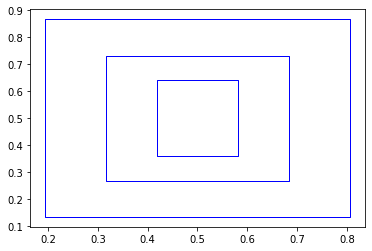

In [16]:
fig, ax = plt.subplots(1)

_ = make_anchor_boxes(ax, final_centers[2])

plt.show()